## Initialization

In [1]:
import os, sys
import torch
import transformers
from torch.utils.data import DataLoader, SequentialSampler
import argparse
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_curve, auc

/opt/conda/envs/myenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
sys.path.append("/home/divy/FiD")

In [3]:
import src
from src.data import load_data
from src.evaluation import ems
import src.model

## Load data

Try out NQ with NQ pretrained checkpoint

In [4]:
nq_path =  "/mnt/disks/external_mounted_disk/datasets/NQ/NQ/dev.json"
compose_path = "/mnt/disks/external_mounted_disk/datasets/compose_FiD/compose_fid_qa/dev.json"


In [5]:
eval_examples = load_data(
                            compose_path,
                            global_rank=0,
                            world_size=1,
                            )

In [6]:
n_passages = 20
eval_dataset = src.data.Dataset(eval_examples, n_passages)

sampler = SequentialSampler(eval_dataset)
tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')
collator = src.data.Collator(200, tokenizer, answer_maxlength=-1)

len(eval_dataset)

/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


386

In [7]:
dataloader = DataLoader(eval_dataset,
        sampler=sampler,
        batch_size=1,
        drop_last=False,
        num_workers=10,
        collate_fn=collator
    )

/opt/conda/envs/myenv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Load model

In [8]:
model_name = 't5-base'
model_class = src.model.FiDT5

In [9]:
load_path = "/home/divy/FiD/model_ckpts/test_experiment_large_fid_qa_compose"
model = model_class.from_pretrained(load_path)

In [10]:
model = model.to('cuda')

### load an example input, generated output and ground truth output

In [12]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    
    if i == 45:
        
        print(idx)
        print(context_ids.shape)
        print(context_ids[0][0])
        for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            break
        
        print("")
        print("")
        print("generated answer:")
        # generated_output = model.generate(
        #         input_ids=context_ids.cuda(),
        #         attention_mask=context_mask.cuda(),
        #         max_length=50
        #     ).cpu()
        
        generated_output, log_prob = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                do_sample=True,
                max_length=150,
                top_p=0.9,
                temperature=1.0,
                output_confidence=True,
                
            )
        
        # generated_output = generated_output.cpu()
        
        # print(generated_output.sequences)
        # print(generated_output.scores)
        
        print(generated_output)
        
        human_readable_generated_output = tokenizer.decode(generated_output[0], skip_special_tokens=True)
        print(human_readable_generated_output)
        print("")
        print("log_prob")
        print(log_prob)
        
#         print("")
#         print("")
#         print("ground truth answer:")

#         print(tokenizer.decode(labels[0], skip_special_tokens=True))

    
        break


tensor([45])
torch.Size([1, 12, 93])
tensor([  822,    10,   363,    33,     8,   192,  2081,     8,  1614,   164,
          177,    63,     3,     9, 11819,    31,     7,  4644,    12,  2025,
           58,  2233,    10,  2625,    10,    37,  8773,    43,     3, 19084,
          796,  6683,    84,   398,    36,     3, 24902,    16,     8,  2510,
           13,     8,  1614,    31,     7, 12962,   138, 11444,    13,   823,
           42,    59,    12,  5334,     3,     9,  4644,    12,  2025,  5669,
            5,     1,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0])
====
0


generated answer:
tensor([[    0,    37,  1614,   164,   177,    63,     3,     9, 11819,    31,
             7,  4644,    12,  2025,     3,    99,    34,  3475,    24,     8,
          2025,    15,    15,    56,  2519,   

In [59]:
softmax = torch.nn.Softmax(dim=1)

In [62]:
print(len(generated_output.scores))

for i in range(len(generated_output.scores)):
    softmaxed = softmax(generated_output.scores[i])
    print("===")
    print(torch.topk(softmaxed, k=5).values)
    print(torch.topk(softmaxed, k=5).indices)
    

31
===
tensor([[0.4420, 0.3441, 0.0951, 0.0292, 0.0180]], device='cuda:0')
tensor([[26135,    37,   818,  1875,    71]], device='cuda:0')
===
tensor([[1.0000e+00, 1.1707e-07, 9.2245e-08, 2.3226e-08, 1.7442e-08]],
       device='cuda:0')
tensor([[   7,   16, 6120, 8542, 3213]], device='cuda:0')
===
tensor([[1.0000e+00, 6.8337e-09, 4.0779e-09, 2.7640e-09, 2.2542e-09]],
       device='cuda:0')
tensor([[16, 86,  3, 21, 12]], device='cuda:0')
===
tensor([[9.9998e-01, 1.4577e-05, 4.0844e-07, 4.5202e-08, 3.4458e-08]],
       device='cuda:0')
tensor([[    3, 11458,    46, 15488,     8]], device='cuda:0')
===
tensor([[1.0000e+00, 2.3095e-07, 9.9272e-09, 7.3583e-09, 4.7471e-09]],
       device='cuda:0')
tensor([[   9,    3,    5,    2, 2533]], device='cuda:0')
===
tensor([[1.0000e+00, 4.0756e-09, 1.6611e-10, 8.4022e-11, 6.8444e-11]],
       device='cuda:0')
tensor([[11458, 15488,   726,  5347,   549]], device='cuda:0')
===
tensor([[1.0000e+00, 2.3191e-06, 3.9558e-07, 2.4090e-08, 1.6732e-08]],
  

In [69]:
print(len(generated_output.scores))

for i in range(len(generated_output.scores)):
    softmaxed = softmax(generated_output.scores[i]) + 1e-4
    print("====")
    print(torch.topk(softmaxed, k=5).values)
    print(torch.topk(softmaxed, k=5).indices)    

42
====
tensor([[4.8560e-01, 3.7805e-01, 1.0460e-01, 3.2149e-02, 1.0000e-04]],
       device='cuda:0')
tensor([[26135,    37,   818,  1875,     0]], device='cuda:0')
====
tensor([[1.0001e+00, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04]],
       device='cuda:0')
tensor([[7, 2, 0, 3, 1]], device='cuda:0')
====
tensor([[1.0001e+00, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04]],
       device='cuda:0')
tensor([[16,  2,  0,  3,  1]], device='cuda:0')
====
tensor([[1.0001e+00, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04]],
       device='cuda:0')
tensor([[3, 2, 0, 4, 1]], device='cuda:0')
====
tensor([[1.0001e+00, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04]],
       device='cuda:0')
tensor([[9, 2, 0, 3, 1]], device='cuda:0')
====
tensor([[1.0001e+00, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04]],
       device='cuda:0')
tensor([[11458,     2,     0,     3,     1]], device='cuda:0')
====
tensor([[1.0001e+00, 1.0000e-04, 1.0000e-04, 1.0000e-04, 1.0000e-04]],
       device='cud

In [32]:
softmax = torch.nn.Softmax(dim=1)
print(torch.topk(generated_output.scores[0], k=10))

torch.topk(softmax(generated_output.scores[0]), k=10)

torch.return_types.topk(
values=tensor([[ -3.4827, -12.0447, -12.2468, -13.4098, -13.6501, -13.7378, -14.1303,
         -14.4776, -14.6159, -15.7222]], device='cuda:0'),
indices=tensor([[  389,    71,  2372,  3526,   156, 30413,  5331,   366,  2840,    37]],
       device='cuda:0'))


torch.return_types.topk(
values=tensor([[9.9945e-01, 1.9113e-04, 1.5616e-04, 4.8807e-05, 3.8380e-05, 3.5159e-05,
         2.3746e-05, 1.6779e-05, 1.4611e-05, 4.8329e-06]], device='cuda:0'),
indices=tensor([[  389,    71,  2372,  3526,   156, 30413,  5331,   366,  2840,    37]],
       device='cuda:0'))

In [34]:
torch.log(torch.tensor(9.9945e-01))

tensor(-0.0006)

## Extract cross attention matrices

In [97]:
len(forward.cross_attentions)

12

In [98]:
stacked_forward_attentions = torch.cat(forward.cross_attentions, dim=0)
stacked_forward_attentions.shape

torch.Size([12, 12, 3, 880])

In [99]:
torch.mean(stacked_forward_attentions[:, :, 0, :])

tensor(-80681824., device='cuda:0', grad_fn=<MeanBackward0>)

In [34]:
forward.cross_attentions[0].shape

torch.Size([1, 12, 3, 322])

In [35]:
torch.mean(forward.cross_attentions[0][:, :, 0, :])

tensor(-27950314., device='cuda:0', grad_fn=<MeanBackward0>)

In [36]:
forward.cross_attentions[0].shape

torch.Size([1, 12, 3, 322])

In [37]:
torch.sum(forward.cross_attentions[3], dim=-1).shape

torch.Size([1, 12, 3])

In [38]:
torch.sum(forward.cross_attentions[0], dim=-1)

tensor([[[-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09],
         [-9.0000e+09, -9.0000e+09, -9.0000e+09]]], device='cuda:0',
       grad_fn=<SumBackward1>)

In [30]:
forward.cross_attentions[0][0][0][1]

tensor([ 1.9729e+00,  1.3851e+00, -2.1832e+00, -1.1376e+00, -1.2776e+00,
        -3.4125e+00, -5.3054e+00, -4.8791e+00, -3.2870e+00, -4.4425e+00,
        -1.8687e+00, -2.5599e+00, -2.6223e+00, -4.1923e+00, -1.3342e+00,
        -5.2764e-01,  5.1298e-01, -4.1823e+00, -4.5534e+00, -3.5556e+00,
        -4.6796e+00, -8.2563e-01,  9.5785e-01, -3.3178e+00, -3.6698e+00,
        -3.0187e+00, -4.7601e+00, -4.2497e+00, -2.8946e+00, -5.3650e+00,
        -3.4801e+00, -4.4688e+00, -3.2278e+00, -4.8753e+00, -3.7288e+00,
        -1.9606e+00,  1.3321e+00, -3.6053e+00, -1.8468e+00, -4.1075e+00,
        -2.9598e+00, -2.5535e+00, -2.2707e+00, -3.5604e+00, -3.8036e+00,
        -2.4402e+00, -4.0344e+00, -2.8101e+00, -5.1451e+00, -1.9998e+00,
        -1.9949e+00,  1.3623e+00, -9.9303e-01,  8.5180e-01, -2.4537e-01,
        -1.4495e+00, -1.2180e+00,  5.8565e-01,  6.4136e-01,  1.1378e+00,
        -8.3264e-01, -1.4387e+00, -1.5302e+00, -1.3770e+00, -8.3234e-01,
        -5.2860e-01,  2.6433e+00,  3.8919e-01, -9.3

In [248]:
torch.sum(forward.cross_attentions[0], dim=-1)

tensor([[[-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.4000e+10],
         [-2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10, -2.4000e+10,
          -2.4000e+10, -2.400

## compute g_{q,p}

In [182]:
stacked_forward_attentions = torch.cat(forward.cross_attentions, dim=0)

In [183]:
stacked_forward_attentions.shape

torch.Size([12, 12, 3, 1960])

In [184]:
context_mask.shape

torch.Size([1, 10, 196])

In [185]:
msk = torch.reshape(context_mask, (1, context_mask.shape[1]*context_mask.shape[2])).cuda()
msk.shape

torch.Size([1, 1960])

In [186]:
masked_stacked_forward_attentions = stacked_forward_attentions.masked_fill(msk == False, 0.0)

In [187]:
masked_stacked_forward_attentions.shape

torch.Size([12, 12, 3, 1960])

In [188]:
for i in range(context_mask.shape[1]):
    print(i)
    sliced_masked_stacked_forward_attentions = masked_stacked_forward_attentions[:, :, :, (i*context_mask.shape[2]):((i + 1)*context_mask.shape[2])]
    print(sliced_masked_stacked_forward_attentions.shape)
    g_qp = torch.mean(sliced_masked_stacked_forward_attentions[:, :, 0, :])
    print(g_qp)
    print("============")
    

0
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
1
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)
2
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
3
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
4
torch.Size([12, 12, 3, 196])
tensor(0.0007, device='cuda:0', grad_fn=<MeanBackward0>)
5
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
6
torch.Size([12, 12, 3, 196])
tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)
7
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
8
torch.Size([12, 12, 3, 196])
tensor(0.0004, device='cuda:0', grad_fn=<MeanBackward0>)
9
torch.Size([12, 12, 3, 196])
tensor(0.0006, device='cuda:0', grad_fn=<MeanBackward0>)


In [189]:
g_qp = model.obtain_gqp(
    input_ids=context_ids.cuda(),
    attention_mask=context_mask.cuda(),
    decoder_input_ids=labels.cuda(),
    output_attentions=True,
    output_unnormalized_attentions=False
)

g_qp = [el.detach() for el in g_qp]

g_qp

[tensor(0.0006),
 tensor(0.0006),
 tensor(0.0005),
 tensor(0.0005),
 tensor(0.0007),
 tensor(0.0004),
 tensor(0.0005),
 tensor(0.0004),
 tensor(0.0004),
 tensor(0.0006)]

In [161]:
averaged_attention_matrix = torch.mean(masked_stacked_forward_attentions, dim = (0, 1)).detach().cpu().numpy()


### Visualise layer-head averaged cross-attention matrix

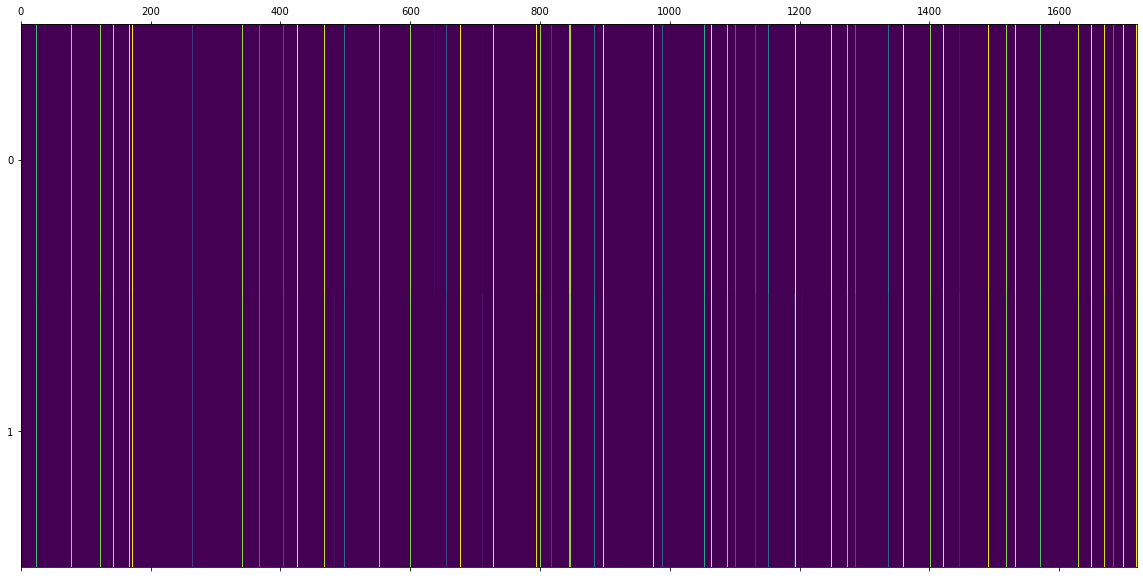

In [162]:
fig = plt.figure(figsize=(20, 10), facecolor="white")
ax = fig.add_subplot()
#ax.imshow(averaged_attention_matrix[:, :], cmap='hot', interpolation='nearest')
ax.matshow(averaged_attention_matrix[:2, :], aspect='auto', vmin=0)

In [86]:
averaged_attention_matrix.shape

(2, 1980)

## Obtaining the generative output score

In [17]:
len(dataloader)

386

### Figure out prevalence of very confident, correct vs incorrect answers

In [11]:
# only one context vector

exact_match_log_probabilities = []
incorrect_log_probabilities = []
exact_match_answers = []

for i, batch in tqdm(enumerate(dataloader)):
    
    (idx, _, _, context_ids, context_mask) = batch
    sequences = model.generate(
                input_ids=context_ids.cuda(),
                attention_mask=context_mask.cuda(),
                max_length=100,
                return_dict_in_generate=True,
                output_scores=True
            ).sequences

    
    for k, o in enumerate(sequences):
        ans = tokenizer.decode(o, skip_special_tokens=True)
        gold = eval_dataset.get_example(idx[k])['answers']
        score = ems(ans, gold)
        #print(score)
        # total += 1
        # exactmatch.append(score)
#         print("model generated output:")
#         print(ans)

#         print("")
#         print("ground truth:")
#         print(gold) 

    # print("extracting negative log probability ...")
    log_probability = model.obtain_log_generated_probability(
        input_ids=context_ids.cuda(),
        attention_mask=context_mask.cuda(),
        max_length=100

    )
    
    if score == True:
        exact_match_log_probabilities.append(log_probability.cpu().numpy())
        exact_match_answers.append(ans)
#         if len(exact_match_log_probabilities) >= 5:
#             print("exceeded five exact matches")
        
#         if len(exact_match_log_probabilities) >= 10:
#             print("exceeded ten exact matches")
    
    else:
        incorrect_log_probabilities.append(log_probability.cpu().numpy())
        
    if i >= 0:
        break


0it [00:00, ?it/s]/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/modeling_utils.py:699: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/opt/conda/envs/myenv/lib/python3.9/site-packages/transformers/modeling_utils.py:656: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
0it [00:05, ?it/s]


In [14]:
# load from local
exact_match_log_probabilities = np.load("../numpy_drops/exact_matches_dev_sampling.npy")
incorrect_log_probabilities = np.load("../numpy_drops/incorrects_dev_sampling.npy")
rouge_match_log_probabilities = np.load("../numpy_drops/rouge_matches_dev_sampling.npy")

In [15]:
with open("../numpy_drops/rouge_similarity_answers_dev_sampling", "rb") as f:
    rouge_matches = pickle.load(f)

len(rouge_matches)

169

In [16]:
len([el for el in rouge_matches if el[2] == 1.0])

41

In [17]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

In [18]:
print("rouge match distribution")
print(len(rouge_match_log_probabilities))
print(np.mean(rouge_match_log_probabilities))
print(np.std(rouge_match_log_probabilities))

rouge match distribution
169
0.0357833
0.043356366


In [19]:
print("exact match distribution")
print(len(exact_match_log_probabilities))
print(np.mean(exact_match_log_probabilities))
print(np.std(exact_match_log_probabilities))

exact match distribution
40
0.008366695
0.02236939


In [20]:
print("incorrect match distribution")
print(len(incorrect_log_probabilities))
print(np.mean(incorrect_log_probabilities))
print(np.std(incorrect_log_probabilities))

incorrect match distribution
217
0.11599405
0.105956756


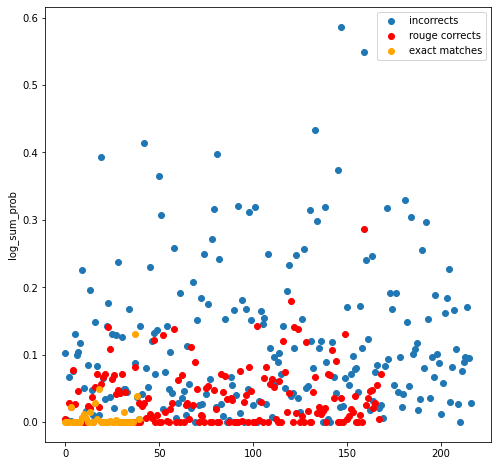

In [21]:
fig = plt.figure(figsize=(8,8), facecolor="white")
ax = fig.add_subplot(111)
ax.scatter(list(range(len(incorrect_log_probabilities))), incorrect_log_probabilities, label="incorrects")
ax.scatter(list(range(len(rouge_match_log_probabilities))), rouge_match_log_probabilities, color="red", label="rouge corrects")
ax.scatter(list(range(len(exact_match_log_probabilities))), exact_match_log_probabilities, color="orange", label="exact matches")
ax.set_ylabel("log_sum_prob")
ax.legend()

In [22]:
exact_match_log_probabilities

array([0.        , 0.        , 0.        , 0.02162201, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00580232,
       0.0117473 , 0.00572506, 0.        , 0.01535299, 0.        ,
       0.        , 0.02833158, 0.0049893 , 0.04908391, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00164928,
       0.        , 0.        , 0.00288065, 0.        , 0.        ,
       0.        , 0.01439388, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1299778 , 0.03929619, 0.00381554],
      dtype=float32)

In [55]:
zipped_rouge = list(zip(rouge_matches, rouge_match_log_probabilities))

inexact_matches = [el for el in zipped_rouge if el[0][2] != 1.0]

inexact_match_log_probabilities = list(zip(*inexact_matches))[1]


In [89]:
# rouge-l correctness
corrects_rouge = list(rouge_match_log_probabilities)
incorrects_rouge = list(incorrect_log_probabilities)

y_scores_rouge = corrects_rouge + incorrects_rouge
y_true_rouge = list(np.zeros(len(corrects_rouge)).astype(int)) + list(np.ones(len(incorrects_rouge)).astype(int))

# exact match correctness
corrects_exact = list(exact_match_log_probabilities)
incorrects_exact = list(incorrect_log_probabilities) + list(inexact_match_log_probabilities)

y_scores_exact = corrects_exact + incorrects_exact
y_true_exact = list(np.zeros(len(corrects_exact)).astype(int)) + list(np.ones(len(incorrects_exact)).astype(int))

In [90]:
len(corrects_rouge) + len(incorrects_rouge)

3466

In [142]:
threshold = 0.01

label_scores = list(zip(y_true_rouge, y_scores_rouge))

predicted_positive = [el for el in label_scores if el[1] <= threshold]
predicted_negative = [el for el in label_scores if el[1] > threshold]

true_positive = len([el for el in predicted_positive if el[0] == 0])
false_positive = len([el for el in predicted_positive if el[0] == 1])

true_negative = len([el for el in predicted_negative if el[0] == 1])
false_negative = len([el for el in predicted_negative if el[0] == 0])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)


print(f"precision: {precision}")
print(f"recall: {recall}")

precision: 0.7317574511819116
recall: 0.4906960716747071


In [143]:
true_positive + false_negative

1451

In [144]:
total_examples = len(rouge_match_log_probabilities) + len(incorrect_log_probabilities)

print(f"total examples: {total_examples}")

allowed_through = true_positive + false_positive

fraction_allowed_through = allowed_through / total_examples

print(f"fraction allowed through: {fraction_allowed_through}")

total examples: 3466
fraction allowed through: 0.2807270628967109


### PR curve

In [60]:
def obtain_p_and_r(y_true, y_pred, thresholds):
    
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        label_scores = list(zip(y_true, y_pred))

        predicted_positive = [el for el in label_scores if el[1] <= threshold]
        predicted_negative = [el for el in label_scores if el[1] > threshold]

        true_positive = len([el for el in predicted_positive if el[0] == 0])
        false_positive = len([el for el in predicted_positive if el[0] == 1])

        true_negative = len([el for el in predicted_negative if el[0] == 1])
        false_negative = len([el for el in predicted_negative if el[0] == 0])

        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)

        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls
        

In [61]:
thresholds = np.linspace(0, 1, 101)

precisions_rouge, recalls_rouge = obtain_p_and_r(y_true_rouge, y_scores_rouge, thresholds)
precisions_exact, recalls_exact = obtain_p_and_r(y_true_exact, y_scores_exact, thresholds)

precisions_rouge = [1.0] + precisions_rouge + [0.0]
recalls_rouge = [0.0] + recalls_rouge + [1.0]

precisions_exact = [1.0] + precisions_exact + [0.0]
recalls_exact = [0.0] + recalls_exact + [1.0]

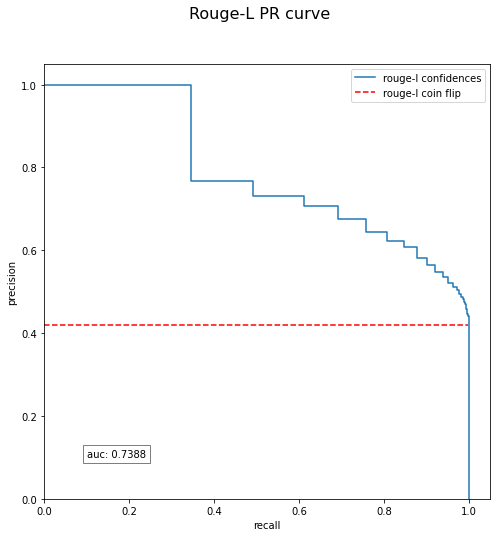

In [113]:
fig = plt.figure(figsize=(8,8), facecolor="white")
fig.suptitle("Rouge-L PR curve", fontsize=16)
ax = fig.add_subplot(111)

ax.step(recalls_rouge, precisions_rouge, label="rouge-l confidences", where='post')
plt.axhline(1 - sum(y_true_rouge) / len(y_true_rouge), xmin=0.0, xmax=0.95, linestyle='--', color="red", label="rouge-l coin flip")
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.text(0.1, 0.1, "auc: {:.4f}".format(auc(recalls_rouge, precisions_rouge)), bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

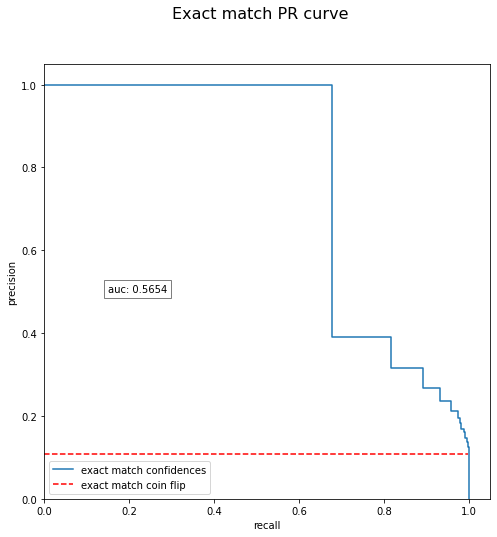

In [83]:
fig = plt.figure(figsize=(8,8), facecolor="white")
fig.suptitle("Exact match PR curve", fontsize=16)
ax = fig.add_subplot(111)

# ax.plot(recalls_exact, precisions_exact)
ax.step(recalls_exact, precisions_exact, label="exact match confidences", where='post')
plt.axhline(1 - sum(y_true_exact) / len(y_true_exact), xmin=0.0, xmax=0.95, linestyle='--', color="red", label="exact match coin flip")
ax.set_xlim([0.0, 1.05])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("recall")
ax.set_ylabel("precision")
ax.text(0.15, 0.5, "auc: {:.4f}".format(auc(recalls_exact, precisions_exact)), bbox=dict(facecolor='white', alpha=0.5))
ax.legend()

### inspect some generated sentences

In [46]:
for i, batch in enumerate(dataloader):
    (idx, labels, _, context_ids, context_mask) = batch
    for j in range(context_ids.shape[1]):

            print("====")
            print(j)
            context = tokenizer.decode(context_ids[0][j])
            print(context)
            if j >= 0:
                break
    
    if i > 0:
        break


====
0
question: When does the statute of limitations period begin for a plaintiff who experiences a continuing practice and policy of discrimination? title: context: Under this approach, if a plaintiff experienced a continuous policy or practice of discrimination, the continuing-violation doctrine delays the commencement of the statute-of-limitations period until the occurrence of the last discriminatory act in furtherance of that discriminatory practice.</s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <

In [24]:
[el for el in rouge_matches if el[2] == 1.0][:20]

[('An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  'An arbitration agreement that gives one party the sole power to select the arbitrator is substantively unconscionable.',
  1.0,
  2),
 ('A defendant who obtains a dismissal can be considered the prevailing party.\xa0',
  'A defendant who obtains a dismissal can be considered the prevailing party.',
  1.0,
  19),
 ('Pre-judgment interest is available in Title VII cases as part of the back pay remedy.',
  'Pre-judgment interest is available in Title VII cases as part of the back pay remedy.',
  1.0,
  35),
 ('When taking an oral deposition, a party can choose whether to adjourn the examination before moving for an order, or move for such an order after the completion of the deposition.',
  'When taking an oral deposition, a party can choose whether to adjourn the examination before moving for an order, or move for such an order after the completion of the deposit

#### 

### Obtain example generated vs ground truth outputs

In [47]:
# only one context vector
for i, batch in enumerate(dataloader):
    
    if i == 7:
        print(f"training example: {i}")
        (idx, _, _, context_ids, context_mask) = batch
        sequences = model.generate(
                    input_ids=context_ids.cuda(),
                    attention_mask=context_mask.cuda(),
                    max_length=10,
                    return_dict_in_generate=True,
                    output_scores=True
                ).sequences

        print(sequences)
        for k, o in enumerate(sequences):
            ans = tokenizer.decode(o, skip_special_tokens=True)
            gold = eval_dataset.get_example(idx[k])['answers']
            score = ems(ans, gold)
            #print(score)
            # total += 1
            # exactmatch.append(score)
            print("model generated output:")
            print(ans)

            print("")
            print("ground truth:")
            print(gold) 
        
        print("extracting negative log probability ...")
        log_probability = model.obtain_log_generated_probability(
            input_ids=context_ids.cuda(),
            attention_mask=context_mask.cuda(),
            max_length=10
            
        )
        
        print(score)
        
        print(log_probability)
        
        break


training example: 7
tensor([[   0, 4407,    1]], device='cuda:0')
model generated output:
2002

ground truth:
['2002']
extracting negative log probability ...
True
tensor(0.6189, device='cuda:0')


In [92]:
softmax = torch.nn.Softmax(dim=1)
total_log_prob = 0
for i in range(len(outputs.scores)):
    print(torch.log(torch.max(softmax(outputs.scores[i]))))
    total_log_prob -= torch.log(torch.max(softmax(outputs.scores[i])))

total_log_prob

tensor(-0.9990, device='cuda:0')
tensor(-0.0031, device='cuda:0')
tensor(-2.1935e-05, device='cuda:0')
tensor(-7.8800e-05, device='cuda:0')
tensor(-0.0035, device='cuda:0')


tensor(1.0057, device='cuda:0')

## Comparing tokenizers

In [31]:
bert_tokenizer = transformers.AutoTokenizer.from_pretrained('bert-base-uncased')
t5_tokenizer = transformers.T5Tokenizer.from_pretrained('t5-base')

In [32]:
input_sequence = "Welcome to the HuggingFace Library"

In [35]:
bert_tokenized = bert_tokenizer(input_sequence, return_tensors='pt')
t5_tokenized = t5_tokenizer(input_sequence, return_tensors='pt')

print(bert_tokenized.input_ids)
print("===")
print(t5_tokenized.input_ids)

tensor([[  101,  6160,  2000,  1996, 17662, 12172,  3075,   102]])
===
tensor([[ 5242,    12,     8, 11560,  3896,   371,  3302,  5355,     1]])


In [40]:
print(bert_tokenizer.decode(bert_tokenized.input_ids[0]))
print("===")
print(t5_tokenizer.decode(t5_tokenized.input_ids[0]))

[CLS] welcome to the huggingface library [SEP]
===
Welcome to the HuggingFace Library</s>


In [46]:
bert_tokenizer.convert_ids_to_tokens(bert_tokenized.input_ids[0])

['[CLS]', 'welcome', 'to', 'the', 'hugging', '##face', 'library', '[SEP]']

In [45]:
t5_tokenizer.convert_ids_to_tokens(t5_tokenized.input_ids[0])

['▁Welcome', '▁to', '▁the', '▁Hug', 'ging', 'F', 'ace', '▁Library', '</s>']

In [52]:
z = torch.randn((2, 4))

In [54]:
msk = torch.tensor([[True, False, True], [False, True, False]])
msk2 = torch.tensor([[True, False, True, True]])

In [43]:
z

tensor([[-1.1771,  0.8998, -0.6725],
        [-1.0138,  1.7796, -0.3884]])

In [55]:
z.masked_fill(msk2 == 0, 0.0)

tensor([[ 1.3247,  0.0000, -0.0618, -0.7110],
        [-0.9271,  0.0000,  0.5299,  0.6540]])

In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
tokenizer = T5Tokenizer.from_pretrained('t5-small')
import torch

In [2]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')

In [3]:
input_ids = tokenizer.encode("summarise: I am originally from siberia, where the sky is green", return_tensors="pt")  # Batch size 1


In [30]:
outputs = model.generate(input_ids, 
                          return_dict_in_generate=True, 
                          output_scores=True, 
                          num_beams=1,
                          do_sample=True,
                          top_k=3,
                          temperature=1.0
                          )


outputs.sequences

tensor([[    0,  2432,  2160,     7,    15,    10,  1674, 26212,   403,   108,
          8781,  1779, 22655,     6,  2275,    67, 23537,     7, 22387,     3]])

In [31]:
scores = outputs.scores

In [36]:
torch.topk(scores[2][0], k=3).indices

tensor([   7, 2248, 5202])

In [21]:
len(scores)

12

In [22]:
softmax = torch.nn.Softmax(dim=1)
softmax(scores[0])

tensor([[8.6265e-07, 1.0719e-02, 7.2606e-06,  ..., 6.3396e-19, 6.0439e-19,
         6.1077e-19]])

In [145]:
scores[4][0]

tensor([-25.0806, -11.4120, -15.4883,  ..., -47.4939, -47.5193, -47.6304])

In [147]:
scores[4][0][sequence[0][5]]

tensor(-3.8385)

In [155]:
torch.argmax(scores[11])

tensor(1)

In [26]:
ans = []
for i in range(len(scores)):
    sfx = softmax(scores[i])
    ans.append(sfx[0][sequence[0][i + 1]])

In [384]:
y_true = np.array([0, 0, 1, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8, 0.9])

precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)


In [391]:
threshold = 0.35

label_scores = list(zip(y_true, y_scores))

predicted_positive = [el for el in label_scores if el[1] >= threshold]
predicted_negative = [el for el in label_scores if el[1] < threshold]

true_positive = len([el for el in predicted_positive if el[0] == 1])
false_positive = len([el for el in predicted_positive if el[0] == 0])

true_negative = len([el for el in predicted_negative if el[0] == 0])
false_negative = len([el for el in predicted_negative if el[0] == 1])

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

print(precision)
print(recall)


0.75
1.0


In [381]:
thresholds

array([0.1 , 0.35, 0.4 , 0.8 , 0.9 ])

In [386]:
precisions

array([0.6       , 0.75      , 0.66666667, 1.        , 1.        ,
       1.        ])

In [387]:
recalls

array([1.        , 1.        , 0.66666667, 0.66666667, 0.33333333,
       0.        ])